In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
file_path = 'data/normalized_survey_data.xlsx'
normalized_data = pd.read_excel(file_path)

In [6]:
# Display the first few rows of the dataset
normalized_data.head()

,Login Frequency,Time Spent on Canvas,Accessed Optional Module,Check for Emails,Timely Submission,Time on Client Project,Time on SMART Goals,Communication with Coordinator,Communication with Client,Communication with Interns,Internship Meaningful,Internship Difficulty,Learned From Internship,Satisfaction With Support,Overall Engagement
0,3,3,0,3,3,5,3,2,2,3,3,1,3,5,4
1,4,5,0,5,2,4,4,1,2,2,3,2,5,4,4
2,5,5,0,4,2,4,4,2,2,1,3,3,4,3,3
3,3,5,0,3,3,4,1,2,2,2,1,2,3,3,4
4,5,2,1,4,2,4,1,3,2,2,2,3,3,4,3


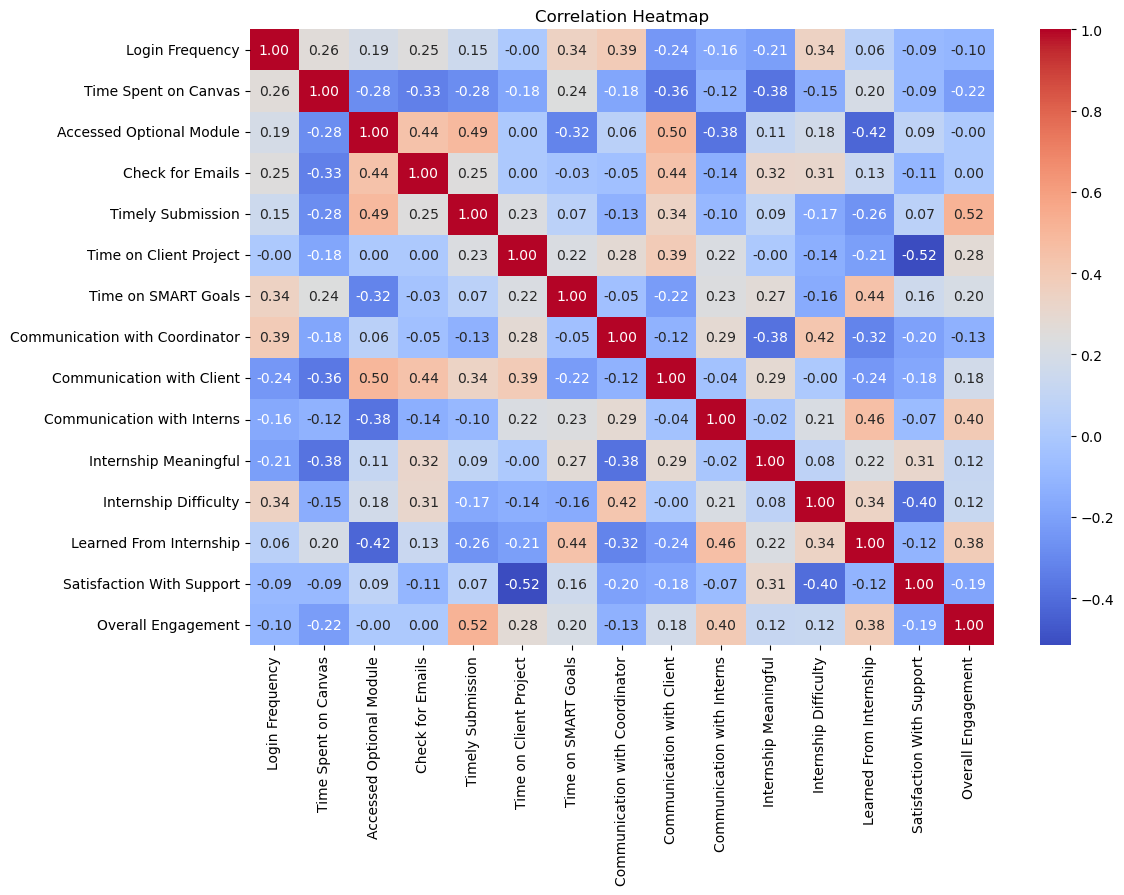

In [7]:
plt.figure(figsize=(12, 8))
correlation_matrix = normalized_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [8]:
X = normalized_data.drop('Overall Engagement', axis=1)
y = normalized_data['Overall Engagement']

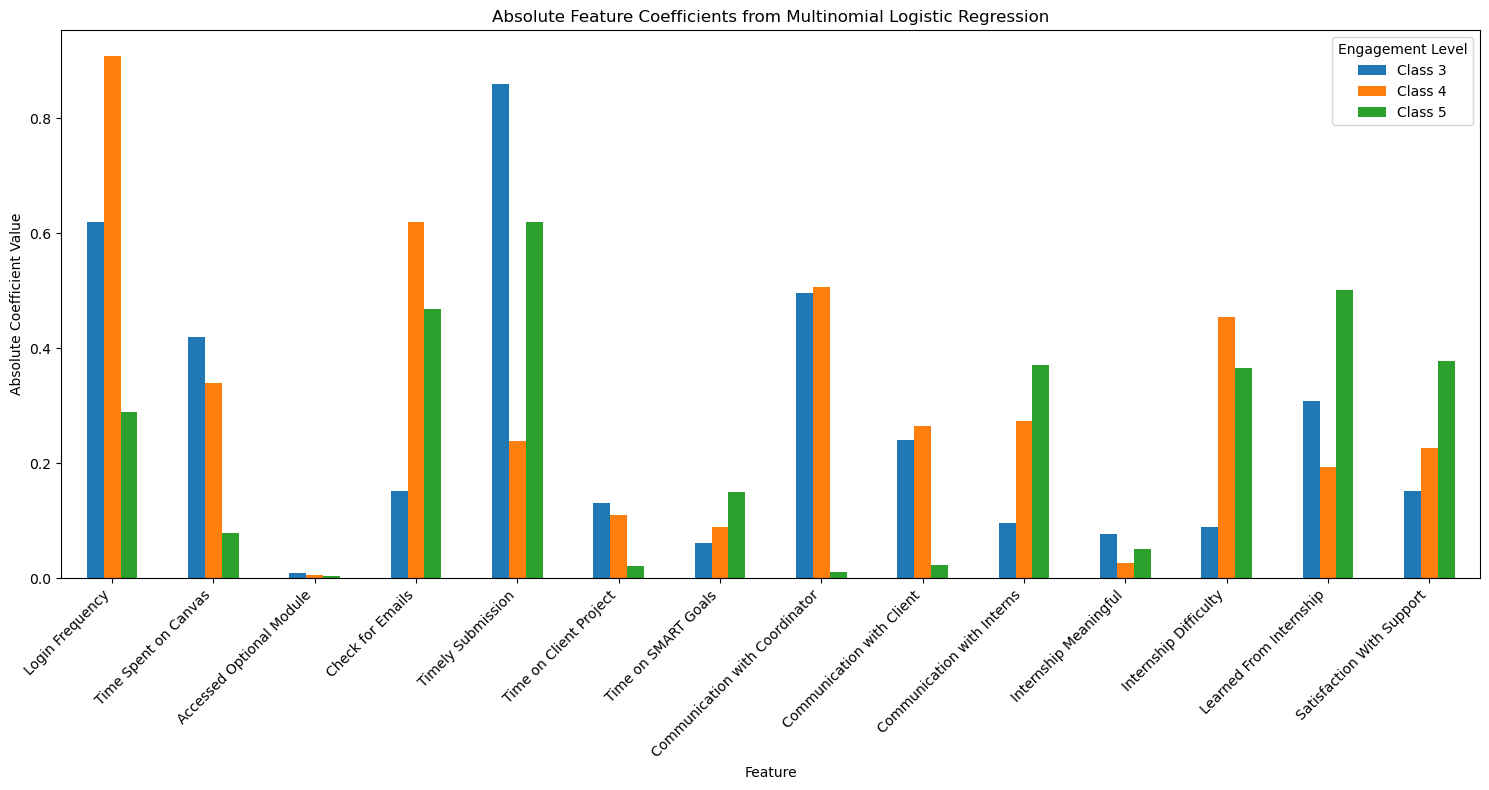

In [9]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Initialize and fit the Logistic Regression model
log_reg = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000)
log_reg.fit(X, y)

# Get feature coefficients and take absolute values
coefficients = np.abs(log_reg.coef_)

# Create a DataFrame for visualization
coefficients_df = pd.DataFrame(coefficients.T, index=X.columns, columns=[f'Class {cls}' for cls in log_reg.classes_])

# Plot absolute feature coefficients with features on the x-axis
coefficients_df.plot(kind='bar', figsize=(15, 8))
plt.title('Absolute Feature Coefficients from Multinomial Logistic Regression')
plt.xlabel('Feature')
plt.ylabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Engagement Level')
plt.tight_layout()
plt.show()

Model Fitting

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

In [11]:
# Define VAE architecture
input_dim = X.shape[1]
latent_dim = 2  # You can adjust the number of latent dimensions

inputs = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(inputs)
h = Dense(64, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Create encoder
encoder = Model(inputs, [z_mean, z_log_var, z])

# Create decoder
latent_inputs = Input(shape=(latent_dim,))
h_decoded = Dense(64, activation='relu')(latent_inputs)
h_decoded = Dense(128, activation='relu')(h_decoded)
outputs = Dense(input_dim, activation='sigmoid')(h_decoded)
decoder = Model(latent_inputs, outputs)

# Create VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

# Define VAE loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train VAE
vae.fit(X, epochs=50, batch_size=32, validation_split=0.2)

# Generate synthetic samples
n_samples = 2000  # Number of synthetic samples you want to generate
z_sample = np.random.normal(size=(n_samples, latent_dim))
X_synthetic = decoder.predict(z_sample)

# Convert to DataFrame
X_synthetic_df = pd.DataFrame(X_synthetic, columns=normalized_data.columns[:-1])

# Combine synthetic data with original data
X_augmented = pd.concat([pd.DataFrame(X, columns=normalized_data.columns[:-1]), X_synthetic_df], axis=0)
y_augmented = pd.concat([pd.Series(y), y.sample(n=n_samples, replace=True, random_state=42)], axis=0)

# Check the new size of the augmented dataset
print(X_augmented.shape, y_augmented.shape)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 107.5575 - val_loss: 122.9762
Epoch 2/50
1/1 [==============================] - 0s 39ms/step - loss: 106.8331 - val_loss: 121.8993
Epoch 3/50
1/1 [==============================] - 0s 41ms/step - loss: 106.4158 - val_loss: 122.7707
Epoch 4/50
1/1 [==============================] - 0s 36ms/step - loss: 105.7609 - val_loss: 122.6757
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 105.1833 - val_loss: 121.7561
Epoch 6/50
1/1 [==============================] - 0s 40ms/step - loss: 105.1997 - val_loss: 121.0587
Epoch 7/50
1/1 [==============================] - 0s 36ms/step - loss: 104.9741 - val_loss: 120.2008
Epoch 8/50
1/1 [==============================] - 0s 43ms/step - loss: 104.3710 - val_loss: 119.4824
Epoch 9/50
1/1 [==============================] - 0s 35ms/step - loss: 103.8201 - val_loss: 118.9657
Epoch 10/50
1/1 [==============================] - 0s 41ms/step - loss: 103.3953 - val_loss: 

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)

In [13]:
from sklearn.neural_network import MLPClassifier

# Neural Network
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network Accuracy: 0.5577557755775577
Neural Network Classification Report:
               precision    recall  f1-score   support

           3       1.00      0.01      0.01       147
           4       0.56      1.00      0.72       337
           5       0.00      0.00      0.00       122

    accuracy                           0.56       606
   macro avg       0.52      0.34      0.24       606
weighted avg       0.55      0.56      0.40       606



d:\Anaconda\envs\atlas\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\atlas\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\atlas\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import joblib

In [16]:
joblib.dump(mlp, 'mlp_classifier_model.pkl')

['mlp_classifier_model.pkl']